## Setup

In [1]:
!hostnamectl

   Static hostname: lorien.atp-fivt.org
         Icon name: computer-server
           Chassis: server
        Machine ID: a3e5546e90014b9b9a9e42d56d79be4a
           Boot ID: 47db86c6e5db447983d85aaaed0e9b8b
  Operating System: Ubuntu 18.04.5 LTS
            Kernel: Linux 4.15.0-206-generic
      Architecture: x86-64


In [2]:
# !pip install --force-reinstall tensorflow==2.3.0
# !pip install tensorflow-addons
# !git clone https://github.com/githubharald/CTCWordBeamSearch.git
# !pip install ./CTCWordBeamSearch
# !(cd ./CTCWordBeamSearch/tests && pytest)

## Data collection

In [3]:
data_dir = '/data_fast/MSMalcev/thesis'

In [4]:
# !wget --save-cookies cookies.txt \
#      --keep-session-cookies \
#      --post-data 'email=sogofi1968@youke1.com&password=Nopassword' \
#      --delete-after \
#      https://fki.tic.heia-fr.ch/login

# !wget --load-cookies cookies.txt -O Downloads/sentences.tgz https://fki.tic.heia-fr.ch/DBs/iamDB/data/sentences.tgz
# !wget --load-cookies cookies.txt -O Downloads/ascii.tgz https://fki.tic.heia-fr.ch/DBs/iamDB/data/ascii.tgz

# !mkdir -p {data_dir}/sentences
# !mkdir -p {data_dir}/ascii
# !tar -xf Downloads/sentences.tgz --directory {data_dir}/sentences
# !tar -xf Downloads/ascii.tgz --directory {data_dir}/ascii

In [5]:
!head -30 {data_dir}/ascii/sentences.txt

#--- sentences.txt -----------------------------------------------------------#
#
# iam database sentence information
#
# format: a01-000u-s0-00 0 ok 154 19 408 746 1663 91 A|MOVE|to|stop|Mr.|Gaitskell|from
#
#     a01-000u-s0-00  -> sentence/line id for form a01-000u
#     0               -> sentence number within this form
#     ok              -> result of word segmentation
#                            ok: line is correctly segmented
#                            er: segmentation of line has one or more errors
#
#                        warning: if a sentence starts or ends in the middle of
#                                 a line which is not correctly segmeted, a
#                                 correct extraction of the sentence can fail.
#
#     154             -> graylevel to binarize line
#     19              -> number of components for this part of the sentence
#     408 746 1663 91 -> bounding box around for this part of the sentence
#                        in the x,y,w,h 

## Imports and setup

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import sys
import os
import re

from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.client import device_lib

from word_beam_search import WordBeamSearch

!nvidia-smi

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_logical_devices('GPU'))

tf.device('/device:GPU:0')

print("Python version " + ' '.join(sys.version.split('\n')))
print("Tensorflow version " + tf.version.VERSION)
!nvcc --version

Sat Apr  1 17:50:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


/home/MSMalcev/.local/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


|   0  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 38%   69C    P2   247W / 250W |   8624MiB / 11019MiB |     96%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:1C:00.0 Off |                  N/A |
| 28%   34C    P8    26W / 250W |     15MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   2  NVIDIA GeForce ...  On   | 00000000:1D:00.0 Off |                  N/A |
| 27%   27C    P8    22W / 250W |   1248MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   3  NVIDIA GeForce ...  On   | 000000

In [7]:
np.random.seed(1)
tf.random.set_seed(1)

## Dataset Preparation

In [8]:
research_dataset_size = 10000

lines_list = []

lines = open(f"{data_dir}/ascii/sentences.txt", "r").readlines()
for line in lines:
    if line[0] == "#":
        continue
    
    if line.split(" ")[1] != "err":
        lines_list.append(line)

# lines_list = lines_list[:research_dataset_size]
np.random.shuffle(lines_list)

print(len(lines_list))
lines_list[:20]

16752


['j01-059-s02-03 2 ok 187 29 347 1676 1656 77 to|the|sodium|by|circlips|on|either|side\n',
 'b05-055-s01-02 1 ok 186 22 347 1091 1775 96 heart|,|a|firm|grip|on|the|willow|and|a|hefty|contempt|for\n',
 "l04-005-s02-00 2 ok 180 39 347 1236 2018 170 '|Well|,|don't|I|get|a|drink|tonight|?|'|she|asked|boldly|.\n",
 'l01-050-s03-01 3 ok 181 25 380 1209 1718 122 eyes|,|wild|and|frightened|,|were|fixed|on\n',
 'c01-009-s00-03 0 err 189 20 310 1450 1036 129 survey|of|a|life|work|.\n',
 'f04-083-s02-03 2 err 161 26 320 2391 1243 59 whom|she|worked|as|a|book-keeper|.\n',
 'm04-107-s03-04 3 ok 171 3 358 2360 432 138 dismay|.\n',
 'b01-073-s04-03 4 ok 172 31 372 2515 1496 73 not|weaken|it|further|by|desertion|.\n',
 'l07-118-s02-00 2 ok 172 14 748 1263 939 104 "|She|,|"|he|corrected|.\n',
 'd06-030-s05-01 5 ok 185 28 374 1440 1782 128 effective|,|must|be|of|that|child-like|quality|which|comes\n',
 'a01-128-s00-01 0 ok 160 20 350 903 1645 145 a|full|minute|-|and|even|his|bitterest|opponents\n',
 'r0

### Splitting

In [9]:
split_idx = int(0.9 * len(lines_list))
train_samples = lines_list[:split_idx]
test_samples = lines_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

In [10]:
base_image_path = f"{data_dir}/sentences"

def get_image_paths_and_labels(samples):
    paths = []
    labels = []
    for _, file_line in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        image_name = line_split[0]
        part1 = image_name.split("-")[0]
        part2 = image_name.split("-")[1]
        img_path = f"{base_image_path}/{part1}/{part1}-{part2}/{image_name}.png"

        if os.path.getsize(img_path):
            paths.append(img_path)
            label = file_line.split("\n")[0].split(" ")[-1].replace('|', ' ').strip()
            labels.append(label)

    return paths, labels


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

train_labels[:20]

['to the sodium by circlips on either side',
 'heart , a firm grip on the willow and a hefty contempt for',
 "' Well , don't I get a drink tonight ? ' she asked boldly .",
 'eyes , wild and frightened , were fixed on',
 'survey of a life work .',
 'whom she worked as a book-keeper .',
 'dismay .',
 'not weaken it further by desertion .',
 '" She , " he corrected .',
 'effective , must be of that child-like quality which comes',
 'a full minute - and even his bitterest opponents',
 'For one',
 "I 'll give",
 'differing in certain important ways from the ordinary cost of',
 'both in the parish and in the wider war activities .',
 'in friends and acquaintances .',
 'average expenditure associated with a child was on cereal foods ,',
 'Once again',
 'But there was ample',
 'The main idea is to have the moulds standing as']

In [11]:
characters = set()
max_len = 0
corpus = ''

for label in train_labels:
    corpus += label + ' '
    for char in label:
        characters.add(char)
    max_len = max(max_len, len(label))

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
print(train_labels[:10])
print(validation_labels[:10])
print(test_labels[:10])

Maximum length:  93
Vocab size:  79
['to the sodium by circlips on either side', 'heart , a firm grip on the willow and a hefty contempt for', "' Well , don't I get a drink tonight ? ' she asked boldly .", 'eyes , wild and frightened , were fixed on', 'survey of a life work .', 'whom she worked as a book-keeper .', 'dismay .', 'not weaken it further by desertion .', '" She , " he corrected .', 'effective , must be of that child-like quality which comes']
['A bully like that respects anyone who', 'important to attempt the task of bringing', 'when in spite of carefully worded state-', 'nuclear tests conference and to the question of disarmament .', "Of course one couldn't say for certain when a", 'Watkinson is right .', "COURSE WAS ' IMMEDIATELY CARRIED INTO", 'circuit a corrosion indicator could be a reference', 'In addition to these revenues , the King had the', 'screws driven from the inside .']
['had been supplied to particular practi-', 'West German Government .', 'around his room ,

In [12]:
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

Initializing word beam search:

In [13]:
# word_chars = 'QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm'
# beam_search = WordBeamSearch(25, 'Words', 0.0, corpus.encode('utf8'), characters.encode('utf8'), word_chars.encode('utf8'))

Resizing images:

In [44]:
batch_size = 64
padding_token = len(characters) + 10
image_width = 2048
image_height = 128

# def resize_image(images, img_size):
#     w, h = img_size
#     images = tf.image.resize_with_pad(images, h, w)

#     # pads_height = h - tf.shape(images)[1]
#     # pads_width = w - tf.shape(images)[1]

#     # if pads_height % 2 != 0:
#     #     height = pads_height // 2
#     #     pad_height_top = height + 1
#     #     pad_height_bottom = height
#     # else:
#     #     pad_height_top = pad_height_bottom = pads_height // 2

#     # if pads_width % 2 != 0:
#     #     width = pads_width // 2
#     #     pad_width_left = width + 1
#     #     pad_width_right = width
#     # else:
#     #     pad_width_left = pad_width_right = pads_width // 2

#     # images = tf.pad(images, paddings=[
#     #     [pad_height_top, pad_height_bottom],
#     #     [pad_width_left, pad_width_right],
#     #     [0, 0],
#     # ])

#     return images

def label_to_sequence(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    
    # if (max_len - length) % 2 != 0:
    #     pad = (max_len - length) // 2
    #     pad_left = pad + 1
    #     pad_right = pad
    # else:
    #     pad_left = pad_right = (max_len - length) // 2
        
    return tf.pad(label, paddings=[[0, max_len - length]], constant_values=padding_token)

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, 1, expand_animations=False)
    return image

def load_image_label(image_path, label):
    image = load_image(image_path)
    label = label_to_sequence(label)
    return (image, label)

def add_noise(images):
    prob = 0.001
    dot_size = tf.random.uniform((), 0, 5, dtype=tf.int32)
    random_values = tf.cond(dot_size == 0,
                            lambda: tf.fill(tf.shape(images), 1.0),
                            lambda: tf.random.uniform([tf.shape(images)[0], tf.shape(images)[1] // dot_size, tf.shape(images)[2] // dot_size, tf.shape(images)[3]]))
    random_values = tf.image.resize(random_values, size=(tf.shape(images)[1], tf.shape(images)[2]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    images = tf.where(random_values < prob, 0.0, images)
    return images

def calculate_otsu_criteria(image, threshold):
    thresholded_image = tf.where(image >= threshold, 1.0, 0.0)

    # compute weights
    nb_pixels = tf.size(image)
    nb_pixels1 = tf.math.count_nonzero(thresholded_image, dtype=tf.int32)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1.0 - weight1

    # if one the classes is empty, eg all pixels are below or above the threshold, that threshold will not be considered
    # in the search for the best threshold
    if weight1 == 0 or weight0 == 0:
        return tf.constant(np.inf, dtype=tf.float64)

    # find all pixels belonging to each class
    val_pixels1 = tf.boolean_mask(image, tf.where(thresholded_image == 1, True, False))
    val_pixels0 = tf.boolean_mask(image, tf.where(thresholded_image == 0, True, False))

    # compute variance of these classes
    var0 = tf.math.reduce_variance(tf.cast(val_pixels0, tf.float64)) if tf.size(val_pixels0) > 0 else tf.constant(0.0, dtype=tf.float64)
    var1 = tf.math.reduce_variance(tf.cast(val_pixels1, tf.float64)) if tf.size(val_pixels1) > 0 else tf.constant(0.0, dtype=tf.float64)

    return weight0 * var0 + weight1 * var1

def otsu_thresholding(image):
    image = tf.cast(image, tf.int32)
    threshold_range = tf.range(0, 256, delta=8, dtype=tf.int32)
    criterias = tf.map_fn(lambda threshold: calculate_otsu_criteria(image, threshold), threshold_range, fn_output_signature=tf.float64)

    threshold = threshold_range[tf.math.argmin(criterias)]
    threshold = threshold
    
    res = tf.where(image > threshold, 255, 0)
    return tf.cast(res, tf.uint8)

def preprocess_image(image):    
    image = tfa.image.gaussian_filter2d(image, filter_shape=10, sigma=1)
    image = otsu_thresholding(image)
    # image = resize_image(image, (image_width, image_height))
    image = tf.image.resize_with_pad(image, image_height, image_width)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def prepare_dataset(image_paths, labels, augment=False):
    augmentation_layers = keras.Sequential([
        preprocessing.RandomRotation(0.001, fill_mode='constant'),
        preprocessing.RandomZoom(height_factor=(-0.05, 0.45), width_factor=0, fill_mode='constant'),
        preprocessing.RandomRotation(0.002, fill_mode='constant'),
        preprocessing.RandomZoom(height_factor=0, width_factor=(-0.05, 0.2), fill_mode='constant'),
        preprocessing.RandomTranslation(height_factor=0.07, width_factor=0, fill_mode='wrap'),
        preprocessing.RandomTranslation(height_factor=0.07, width_factor=0, fill_mode='reflect'),
    ])
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))\
        .map(load_image_label) \
        .map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=batch_size, deterministic=False) \
        .cache() \
        .shuffle(batch_size * 2) \
        .batch(batch_size)
    dataset = dataset.map(lambda x, y: (augmentation_layers(x, training=True), y)).map(lambda x, y: (add_noise(x), y)) if augment else dataset
    
    return dataset.prefetch(5)


In [15]:
train_ds = prepare_dataset(train_img_paths, train_labels, augment=True)
validation_ds = prepare_dataset(validation_img_paths, validation_labels)
test_ds = prepare_dataset(test_img_paths, test_labels)

Cause: could not parse the source code:

        .map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=batch_size, deterministic=False) \
        .cache() \
        .shuffle(batch_size * 2) \
        .batch(batch_size)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

        .map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=batch_size, deterministic=False) \
        .cache() \
        .shuffle(batch_size * 2) \
        .batch(batch_size)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of

## Samples visualization

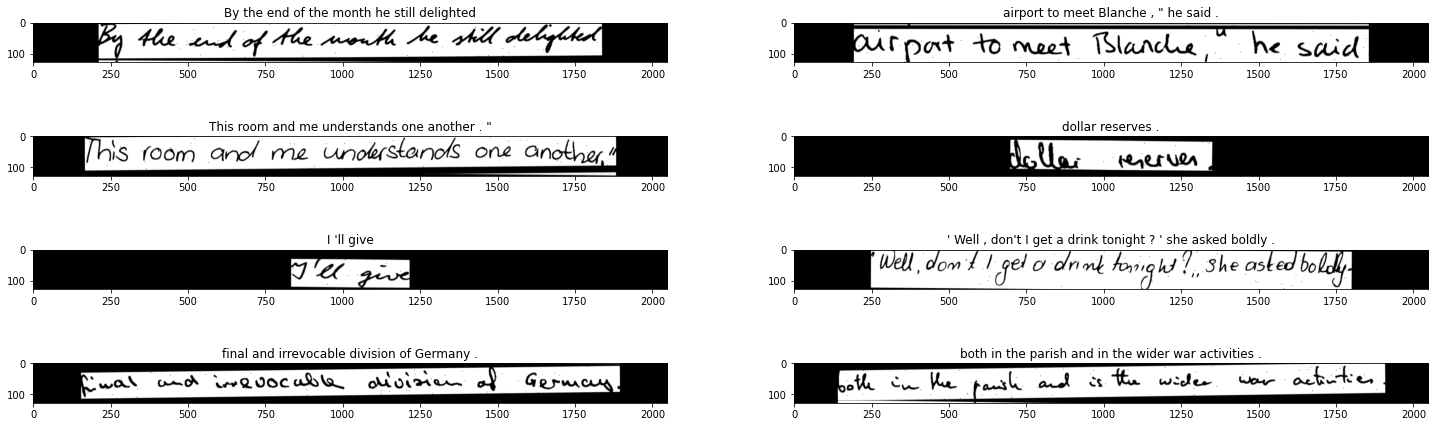

In [16]:
n_examples = 8

_, ax = plt.subplots((n_examples + 1) // 2, 2, figsize=(25, n_examples))
for images, labels in train_ds.take(1):
    for i in range(min(batch_size, n_examples)):
            img = images[i]

            label = labels[i]
            indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
            
            label = tf.strings.reduce_join(num_to_char(indices))
            label = label.numpy().decode("utf-8")

            ax[i // 2, i % 2].imshow(tf.reshape(img, (img.shape[0], img.shape[1])), cmap="gray")
            ax[i // 2, i % 2].set_title(label)
            
            # plt.figure(figsize=(32, 8))
            # plt.imshow(tf.reshape(img, (img.shape[0], img.shape[1])), cmap="gray")
            # plt.show()

plt.show()

## Model

Defining CTC loss:

In [17]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, name='CTCLoss'):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)

        return loss

Defining CER metric:

In [18]:
def pred_batch_to_sequences(pred):
    input_length = tf.ones(tf.shape(pred)[0], dtype=tf.dtypes.int32) * tf.shape(pred)[1]
    return keras.backend.ctc_decode(pred, input_length=input_length, greedy=True)[0][0]
    # return beam_search.compute(tf.transpose(pred, (1, 0, 2)))


def sequences_batch_to_words(sequences):
    lines = []
    for sequence in sequences:
        sequence = tf.gather(sequence, tf.where(tf.math.not_equal(sequence, -1)))
        sequence = tf.strings.reduce_join(num_to_char(sequence)).numpy().decode("utf-8")
        lines.append(sequence)
    
    return lines


class CERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='CER', **kwargs):
        super().__init__(name=name)
        
        self.cer_accumulator = tf.Variable(0.0, name="cer_accumulator", dtype=tf.float32)
        self.batch_counter = tf.Variable(0, name="batch_counter", dtype=tf.int32)
        
        self.vocabulary = tf.constant(list(vocabulary))

    @staticmethod
    def shift_value_right_and_cut(batch, value):
        batch = batch - value
        n_not_zero = tf.math.count_nonzero(batch, -1)

        flat_batch = tf.reshape(batch, [-1])
        mask = tf.math.logical_not(tf.equal(flat_batch, tf.zeros_like(flat_batch)))
        flat_batch_without_zero = tf.boolean_mask(flat_batch, mask)

        ragged_batch = tf.RaggedTensor.from_row_lengths(values=flat_batch_without_zero, row_lengths=n_not_zero)

        padded_batch = ragged_batch.to_tensor(default_value=0)
        padded_batch = padded_batch + value

        return padded_batch

    def get_cer(self, pred_decoded, y_true, error_token=-1):
        vocab_length = tf.cast(tf.shape(self.vocabulary)[0], tf.int64)

        valid_pred_indices = tf.less(pred_decoded, vocab_length)
        valid_pred = tf.where(valid_pred_indices, pred_decoded, error_token)
        valid_pred = self.shift_value_right_and_cut(valid_pred, error_token)

        y_true = tf.cast(y_true, tf.int64)
        valid_true_indices = tf.less(y_true, vocab_length)
        valid_true = tf.where(valid_true_indices, y_true, error_token)
        valid_true = self.shift_value_right_and_cut(valid_true, error_token)

        sparse_pred = tf.sparse.from_dense(valid_pred)
        sparse_true = tf.sparse.from_dense(valid_true)

        distance = tf.edit_distance(sparse_pred, sparse_true, normalize=True)

        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        decoded_sequences = pred_batch_to_sequences(y_pred)
        distance = self.get_cer(decoded_sequences, y_true)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.batch_counter.assign_add(len(y_true))
    
    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.batch_counter.assign(0)

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, tf.cast(self.batch_counter, tf.float32))

Building our model:

In [19]:
def define_model():
    input_img = keras.Input(shape=(image_height, image_width, 1))
    # labels = keras.layers.Input(name="label", shape=(None,))

    x = keras.layers.Permute((2, 1, 3))(input_img)

    x = keras.layers.Conv2D(
        32,
        (5, 5),
        activation="relu",
        padding="same"
    )(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(
        64,
        (5, 5),
        activation="relu",
        padding="same"
    )(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    
    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        padding="same"
    )(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    
    x = keras.layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        padding="same"
    )(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    
    x = keras.layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        padding="same"
    )(x)

    new_shape = ((image_width // 16), (image_height // 16) * 512)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)

    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Bidirectional(
        keras.layers.LSTM(512, return_sequences=True, dropout=0.2)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(256, return_sequences=True, dropout=0.2)
    )(x)

    # two special tokens for CTC.
    output = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax")(x)

    model = keras.models.Model(inputs=[input_img], outputs=output)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=CTCLoss(),
        metrics=[CERMetric(characters)]
    )

    return model


model = define_model()
model.summary()
# keras.utils.plot_model(model)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 2048, 1)]    0         
_________________________________________________________________
permute (Permute)            (None, 2048, 128, 1)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2048, 128, 32)     832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1024, 64, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1024, 64, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 512, 32, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 32, 128)     

## Training

In [20]:
epochs = 50

checkpoint = ModelCheckpoint("/home/MSMalcev/Thesis/model/checkpoint.h5", verbose=1, save_freq=200)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[checkpoint, earlystopper]
)

model.save('/home/MSMalcev/Thesis/model/model.h5')

Epoch 1/50
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
199/236 [========================>.....] - ETA: 47s - loss: 112.6684 - CER: 0.9988
Epoch 00001: saving model to /home/MSMalcev/Thesis/model/checkpoint.h5
236/236 [==============================] - 316s 1s/step - loss: 112.0474 - CER: 0.9990 - val_loss: 106.4821 - val_CER: 1.0000
Epoch 2/50
163/236 [===================>..........] - ETA: 34s - loss: 107.0102 - CER: 0.9947
Epoch 00002: saving model to /home/MSMalcev/Thesis/model/checkpoint.h5
236/236 [==============================] - 115s 486ms/step - loss: 107.1134 - CER: 0.9898 - val_loss: 106.2822 - val_CER: 0.9715
Epoch 3/50
127/236 [===============>..............] - ETA: 52s - loss: 106.6103 - CER: 0.9752
Epoch 00003: saving model to /home/MSMalcev/Thesis/model/checkpoint.h5
236/236 [==============================] - 117s 496ms/step - loss: 106.7768 - CER: 0.9760 - val_loss: 105.5869 - val_CER: 0.9759
Epoch 4/50
 91/236 [==

## Testing

In [58]:
def predict_lines(images, is_preprocessed=False):
    chars_no_space_before = '!),.:;?'
    chars_no_space_after = '('
    
    if not is_preprocessed:
        images = tf.map_fn(preprocess_image, images, fn_output_signature=tf.float32)
    plt.figure(figsize=(20, 4))
    plt.imshow(tf.reshape(images[0], (images.shape[1], images.shape[2])), cmap="gray")
    pred = model.predict(images)
    pred_sequences = pred_batch_to_sequences(pred)
    pred_lines = sequences_batch_to_words(pred_sequences)
    pred_lines = [re.sub(f' ([{chars_no_space_before}])', '\g<1>', line) for line in pred_lines]
    pred_lines = [re.sub(f'([{chars_no_space_after}]) ', '\g<1>', line) for line in pred_lines]
    return pred_lines

14/14 [==============================] - 2s 141ms/step - loss: 9.5339 - CER: 0.0626


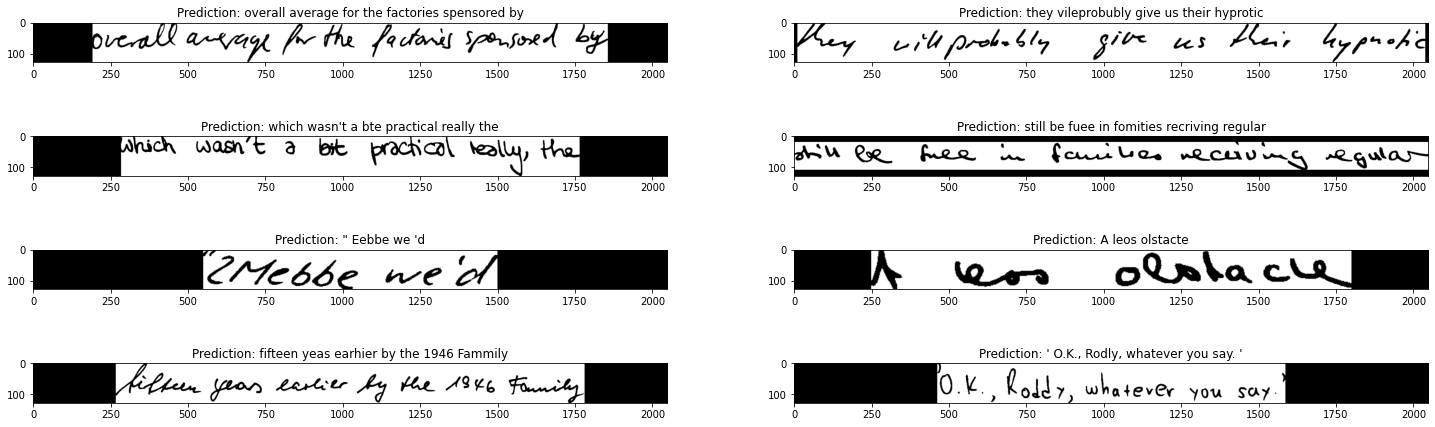

In [56]:
model.evaluate(test_ds)

n_examples = 8

_, ax = plt.subplots((n_examples + 1) // 2, 2, figsize=(25, n_examples))
for images, labels in test_ds.take(1):
    pred_lines = predict_lines(images, True)

    for i in range(min(batch_size, n_examples)):
        img = images[i]

        title = f"Prediction: {pred_lines[i]}"
        ax[i // 2, i % 2].imshow(tf.reshape(img, (img.shape[0], img.shape[1])), cmap="gray")
        ax[i // 2, i % 2].set_title(title)

plt.show()

We got sufficient accuracy for our service.

## Usage

Hells, there is a somple reat for cext recagrniean.


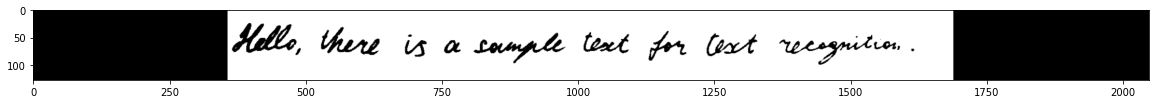

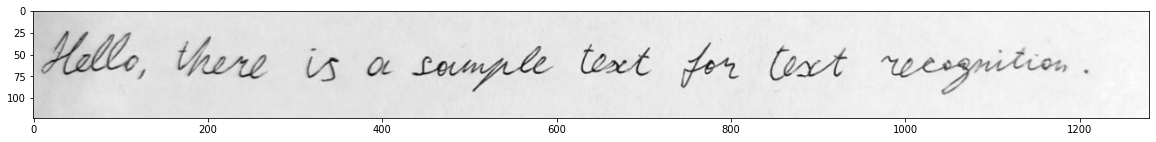

In [61]:
img_path = '/home/MSMalcev/Thesis/test2.jpg' #f"{data_dir}/sentences/a05/a05-004/a05-004-s00-02.png"

model.load_weights('/home/MSMalcev/Thesis/model/model.h5')
image = load_image(img_path)
pred = predict_lines(tf.convert_to_tensor([image]))
print(pred[0])
plt.figure(figsize=(20, 4))
plt.imshow(tf.reshape(image, (image.shape[0], image.shape[1])), cmap="gray")
